In [1]:
%pylab inline
import pandas as pd
import matplotlib as pyplot
import os
from collections import defaultdict

ANNOTDIR = "/storage/mgymrek/gtex/annotations/"
FEATUREDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
mergefile = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Merged_Best_causality.Table'
REGRSSION = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
SCORETYPE = ""
MINDIST = 1500
MINQ = 1
percentiles = [0, 50] + list(np.arange(60, 101, 10))

# Annotate TSS/UTRs
def GetIn(x):
    if x["strand"] == "+":
        return x["best.str.start"] - x["start"]
    elif x["strand"] == "-":
        return -1*(x["best.str.start"] - x["stop"])
    else:
        return float("nan")


def GetBootstrapCI(data, func):
    numiter = 1000
    vals = []
    for i in range(numiter):
        x = np.random.choice(data, size=data.shape[0], replace=True)
        vals.append(func(x))
    se = np.sqrt(np.var(vals))
    return np.mean(vals)-1.96*se, np.mean(vals)+1.96*se


Populating the interactive namespace from numpy and matplotlib


In [3]:
#
data = pd.read_csv(os.path.join(FEATUREDIR, "Merged_Causality_TSS_TSS.tab%s"%SCORETYPE), sep="\t")
data = data[np.isfinite(data['best.str.start'])]
data['str.start']=data['best.str.start'].astype(int)
GG   = pd.read_csv(REGRSSION, sep='\t')
data1 = pd.merge(data, GG[['chrom','str.start', 'gene','str.end','motif','E.tissues']], on=['chrom', 'str.start','gene' ] )
data1['loci']= list(data1["chrom"]+":"+data1["str.start"].astype(str))
data1[["chrom","str.start","str.end"]].to_csv('all_analyzed_strs.bed', sep='\t', header=None, index=None)

In [3]:
%%bash
# Get all STRs analyzed
BASEDIR=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue
cat ${BASEDIR}/GTEx_merged_causality_tsstes.tab | grep -v gene | awk '{print $2 "\t" $3 "\t" $3+1}' |sort | uniq >all_analyzed_strs.bed

In [9]:
data_to_plot = {}
Histones =['H3K27ac_GM12878.bed.gz','H3K27me3_GM12878.bed.gz','H3K36me3_GM12878.bed.gz','H3K4me1_GM12878.bed.gz','H3K4me2_GM12878.bed.gz','H3K4me3_GM12878.bed.gz','H3K79me2_GM12878.bed.gz','H3K9ac_GM12878.bed.gz']
Histone_Rep='/storage/mgymrek/gtex/tfbs/encodedata/'
features = []
for Htype in Histones:
    L = Htype.split('_')[0]
    features.append(L)
    #
    annot = os.path.join(Histone_Rep, Htype)
    cmd = "bedtools intersect -a all_analyzed_strs.bed -b %s > Intersect.bed"%annot
    returned_value = os.system(cmd)
    #
    Inter = pd.read_csv('Intersect.bed', sep='\t', header=None, names=["chrom","start","end"])
    Feature_strs = list(set(Inter.apply(lambda x: x["chrom"]+":"+str(x["start"]), 1)))
    #
    data1[L] = np.where(data1['loci'].isin(Feature_strs), 1, 0)

In [10]:
#Run this multiple time with different location by uncommenting the feature file 
Gene_location = ['3utr.bed', '5utr.bed','coding.bed', 'introns.bed' ]
for Location in Gene_location:
    L = Location.split('.')[0]
    features.append(L)
    #
    annot = os.path.join(ANNOTDIR,Location)
    #
    cmd = "bedtools intersect -a all_analyzed_strs.bed -b %s > Intersect.bed"%annot
    returned_value = os.system(cmd)
    #
    Inter = pd.read_csv('Intersect.bed', sep='\t', header=None, names=["chrom","start","end"])
    Feature_strs = list(set(Inter.apply(lambda x: x["chrom"]+":"+str(x["start"]), 1)))
    #
    data1[L] = np.where(data1['loci'].isin(Feature_strs), 1, 0)

In [ ]:
# Plot TSS/TES/UTR
data1 = data1[data1["best.score"] >= 0]
EE =GG.loc[GG['E.tissues']>=1]
data = data1.loc[data1['gene'].isin(list(EE['gene']))].copy()
bins = np.percentile(data[data["best.q"]<=MINQ]["best.score"], q = percentiles)

binlabels = []
tss = []
tss_low = []
tss_high = []
utr = []
utr_low = []
utr_high = []
ntr = []
ntr_low = []
ntr_high = []

cod = defaultdict(list)
cod_low = defaultdict(list)
cod_high = defaultdict(list)

KST = []
for i in range(len(bins)-1):
    lb = bins[i]
    ub = bins[i+1] 
    x = data[(data["best.score"]>lb) & (data["best.score"]<= ub) & (data["best.q"]<=MINQ)]
    KST.append([lb,ub,x])
    print(lb,'\t',ub, x.shape)
    feature_tss = x["dist.to.tss"].apply(lambda x: abs(x)<MINDIST)
    feature_utr = x["5utr"].apply(lambda x: abs(x)>0)
    feature_ntr = x["introns"].apply(lambda x: abs(x)>0)
    count_tss = np.mean(feature_tss)
    count_utr = np.mean(feature_utr)
    count_ntr = np.mean(feature_ntr)
    low_tss, high_tss = GetBootstrapCI(feature_tss, np.mean)
    low_t, high_t = GetBootstrapCI(feature_utr, np.mean)
    low_int, high_int = GetBootstrapCI(feature_ntr, np.mean)
    if i == 0:
        base_tss = count_tss
        base_t = count_utr
        base_int = count_ntr
    COD_H=[]
    for h in features[:len(Histones)-1]:
        feature_cod = x[h].apply(lambda x: abs(x)>0)    #cod===Histones
        count_cod = np.mean(feature_cod)
        low_cod, high_cod = GetBootstrapCI(feature_cod, np.mean)
        if i == 0:
            base_cod=count_cod
        COD_H.append([h, count_cod, low_cod, high_cod, base_cod])
    #        
    binlabels.append("%s-%s"%(percentiles[i], percentiles[i+1]))
    tss.append(count_tss*1.0/base_tss)
    tss_low.append(low_tss*1.0/base_tss)
    tss_high.append(high_tss*1.0/base_tss)
    utr.append(count_utr*1.0/base_t)
    utr_low.append(low_t*1.0/base_t)
    utr_high.append(high_t*1.0/base_t)
    ntr.append(count_ntr*1.0/base_int)
    ntr_low.append(low_int*1.0/base_int)
    ntr_high.append(high_int*1.0/base_int)
    #
    for j in range(len(Histones)-1):
        h=COD_H[j]
        cod[h[0]].append(h[1]*1.0/h[4] )
        cod_low[h[0]].append(h[2]*1.0/h[4])
        cod_high[h[0]].append(h[3]*1.0/h[4])
        

In [ ]:
fig = plt.figure()
fig.set_size_inches((10, 5))
COL = ['m','maroon', 'navy','lightblue', 'pink', 'mediumpurple', 'orange','yellow']
# TSS
ax = fig.add_subplot(121)
#ax.errorbar(range(len(binlabels)), tss, marker="o", yerr = [tss_low, tss_high])
ax.plot(range(len(binlabels)), tss, marker="o", label='TSS', color='g')
ax.plot(range(len(binlabels)), utr, marker="o", color='r', label='UTRs')
ax.plot(range(len(binlabels)), ntr, marker="o", color='k', label='Introns')
i=0
for h in features[:len(Histones)-1]:
    ax.plot(range(len(binlabels)), cod[h], marker=".", color=COL[i], label = h)
    i=i+1

ax.set_xlabel("Causality Score bins", size=15)
ax.set_ylabel("Enrichment vs. (0,0.5) bin", size=15)
ax.set_xticks(range(len(binlabels)))
ax.set_xticklabels(binlabels, size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.axhline(y = 1.0, linestyle="dashed", color="gray")
ax.set_title("Enrichment of eSTRs with High caviar scores\nWithin %s of TSS of target gene\nAnd for overlapping different regions of a gene  "%MINDIST)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.tight_layout()

In [ ]:
#08/23/18
fig = plt.figure()
fig.set_size_inches((10, 5))
COL = ['m','maroon', 'navy','lightblue', 'pink', 'mediumpurple', 'orange','yellow']
# TSS
ax = fig.add_subplot(121)
#ax.errorbar(range(len(binlabels)), tss, marker="o", yerr = [tss_low, tss_high])
ax.plot(range(len(binlabels)), tss, marker="o", label='TSS', color='g')
ax.plot(range(len(binlabels)), utr, marker="o", color='r', label='UTRs')
ax.plot(range(len(binlabels)), ntr, marker="o", color='k', label='Introns')
i=0
for h in Histones:
    ax.plot(range(len(binlabels)), cod[h], marker=".", color=COL[i], label = h)
    i=i+1

ax.set_xlabel("Causality Score bins", size=15)
ax.set_ylabel("Enrichment vs. (0,0.5) bin", size=15)
ax.set_xticks(range(len(binlabels)))
ax.set_xticklabels(binlabels, size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.axhline(y = 1.0, linestyle="dashed", color="gray")
ax.set_title("Enrichment of eSTRs with High caviar scores\nWithin %s of TSS of target gene\nAnd for overlapping different regions of a gene  "%MINDIST)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.tight_layout()


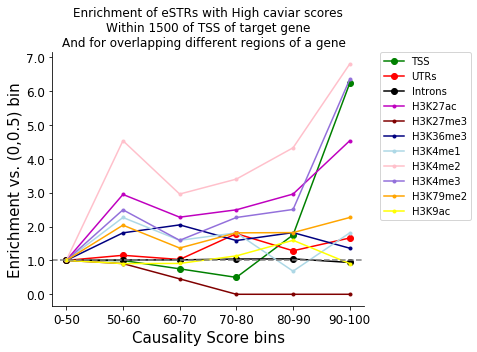

In [18]:
#old
fig = plt.figure()
fig.set_size_inches((10, 5))
COL = ['m','maroon', 'navy','lightblue', 'pink', 'mediumpurple', 'orange','yellow']
# TSS
ax = fig.add_subplot(121)
#ax.errorbar(range(len(binlabels)), tss, marker="o", yerr = [tss_low, tss_high])
ax.plot(range(len(binlabels)), tss, marker="o", label='TSS', color='g')
ax.plot(range(len(binlabels)), utr, marker="o", color='r', label='UTRs')
ax.plot(range(len(binlabels)), ntr, marker="o", color='k', label='Introns')
i=0
for h in Histones:
    ax.plot(range(len(binlabels)), cod[h], marker=".", color=COL[i], label = h)
    i=i+1

ax.set_xlabel("Causality Score bins", size=15)
ax.set_ylabel("Enrichment vs. (0,0.5) bin", size=15)
ax.set_xticks(range(len(binlabels)))
ax.set_xticklabels(binlabels, size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.axhline(y = 1.0, linestyle="dashed", color="gray")
ax.set_title("Enrichment of eSTRs with High caviar scores\nWithin %s of TSS of target gene\nAnd for overlapping different regions of a gene  "%MINDIST)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.tight_layout()


In [20]:
#data["abs.dist.tss"] = abs(data["dist.to.tss"])
#data.sort_values("best.score", ascending=False)
K =KST[-1][-1]
GG['best.str.start'] = GG['str.start']
G = GG[["chrom","best.str.start","gene","motif","E.tissues"]]
DD = pd.merge(K, G, on=["chrom","best.str.start","gene"])
#There are 244 in the top bin
#there are 16 of these causal genes that are eSTRs in more that 9 tissues
DD.loc[DD['E.tissues']>9]#[['gene','best.str.start']]

,gene,chrom,best.str.start,best.score,best.tissue,best.q,dist.to.tss,dist.to.tes,motif,E.tissues
3,ENSG00000121542.7,chr3,122895315,0.283134,Brain-Caudate(basalganglia),0.021620,-25459,-97662,AAAAT,17.0
10,ENSG00000197782.10,chr19,40595525,0.246705,Skin-SunExposed(Lowerleg),0.002642,1135,-20466,AC,11.0
23,ENSG00000177683.9,chr7,108227078,0.737281,Artery-Tibial,0.002820,-17181,-32091,AAAGG,14.0
38,ENSG00000168653.6,chr1,39484711,0.109369,Brain-Caudate(basalganglia),0.036723,-7279,-15597,AAAT,16.0
44,ENSG00000104979.4,chr19,13887758,0.117190,Skin-NotSunExposed(Suprapubic),0.004971,2661,-1518,AAAAAC,12.0
61,ENSG00000067221.9,chr15,74294731,0.168987,Lung,0.003933,-7768,-19184,AC,12.0
139,ENSG00000129187.10,chr4,183838634,0.278416,Artery-Aorta,0.004600,455,-27421,AGGG,10.0
159,ENSG00000124641.10,chr6,41784441,0.335092,Nerve-Tibial,0.002353,104436,88651,AAT,11.0
182,ENSG00000101751.6,chr18,51861538,0.088012,Heart-LeftVentricle,0.006643,65764,13902,AAAT,10.0
190,ENSG00000144214.5,chr2,99841660,0.258215,Brain-Caudate(basalganglia),0.023976,79545,59041,AAGG,12.0
